# Tensorboard

TensorFlow에서 제공하는 시각화 툴입니다. 학습하는 중간의 그래프나 여러가지 정보를 Web UI로 조회할 수 있습니다! 

https://www.tensorflow.org/tensorboard?hl=ko

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
np.random.seed(7777)
tf.random.set_seed(7777)

In [7]:
class Cifar10DataLoader():
    def __init__(self):
        # data load
        (self.train_x, self.train_y), \
            (self.test_x, self.test_y) = tf.keras.datasets.cifar10.load_data()
        self.input_shape = self.train_x.shape[1:]

    def scale(self, x):

        return (x / 255.0).astype(np.float32)

    def preprocess_dataset(self, dataset):

        (feature, target) = dataset

        # scaling #
        scaled_x = np.array([self.scale(x) for x in feature])

        # label encoding #
        ohe_y = np.array([tf.keras.utils.to_categorical(
            y, num_classes=10) for y in target])
        
        return scaled_x, ohe_y.squeeze(1)

    def get_train_dataset(self):
        return self.preprocess_dataset((self.train_x, self.train_y))

    def get_test_dataset(self):
        return self.preprocess_dataset((self.test_x, self.test_y))

cifar10_loader = Cifar10DataLoader()
train_x, train_y = cifar10_loader.get_train_dataset()

print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)

test_x, test_y = cifar10_loader.get_test_dataset()

print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

(50000, 32, 32, 3) float32
(50000, 10) float32
(10000, 32, 32, 3) float32
(10000, 10) float32


In [8]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add

def build_resnet(input_shape):
    inputs = Input(input_shape)

    net = Conv2D(16, kernel_size=3, strides=2,
                 padding='same', activation='relu')(inputs)
    net = MaxPool2D()(net)
    
    net1 = Conv2D(32, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(32, kernel_size=1, padding='same', activation='relu')(net2)
    
    net1_1 = Conv2D(32, kernel_size=1, padding='same')(net)
    net = Add()([net1_1, net3])
    
    net1 = Conv2D(32, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(32, kernel_size=1, padding='same', activation='relu')(net2)
    
    net = Add()([net, net3])
    
    net = MaxPool2D()(net)
    
    net = Flatten()(net)
    net = Dense(10, activation="softmax")(net)

    model = tf.keras.Model(inputs=inputs, outputs=net, name='resnet')
    
    return model

model = build_resnet((32, 32, 3))
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 16)   448         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 8, 8, 16)    0           ['conv2d_8[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 8, 8, 32)     544         ['max_pooling2d_2[0][0]']        
                                                                                             

### fit 함수로 학습 할 때는 callback 함수로 사용! 

In [9]:
learning_rate = 0.03
opt = tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [15]:
model.fit(x=train_x, 
          y=train_y, 
          epochs=5,
          validation_data=(test_x, test_y),
         )

/usr/local/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
1563/1563 [==============================] - 21s 13ms/step - loss: 2.3393 - accuracy: 0.1000 - val_loss: 2.3277 - val_accuracy: 0.1000
Epoch 2/5
1563/1563 [==============================] - 22s 14ms/step - loss: 2.3402 - accuracy: 0.1017 - val_loss: 2.3555 - val_accuracy: 0.1000
Epoch 3/5
1563/1563 [==============================] - 22s 14ms/step - loss: 2.3421 - accuracy: 0.0991 - val_loss: 2.3084 - val_accuracy: 0.1000
Epoch 4/5
1563/1563 [==============================] - 22s 14ms/step - loss: 2.3434 - accuracy: 0.0991 - val_loss: 2.3140 - val_accuracy: 0.1000
Epoch 5/5
1563/1563 [==============================] - 22s 14ms/step - loss: 2.3445 - accuracy: 0.1014 - val_loss: 2.4095 - val_accuracy: 0.1000


In [18]:
!tensorboard --logdir logs/fit --bind_all


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.7.0 at http://Brians-MacBook-Pro.local:6006/ (Press CTRL+C to quit)
^C


### tf.summary 사용하기!

In [19]:
loss_fn = tf.keras.losses.categorical_crossentropy

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(x, y) :
    with tf.GradientTape() as tape:
        pred = model(x)
        loss = loss_fn(y, pred)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(y, pred)

@tf.function
def test_step(x, y) :
    
    pred = model(x)
    loss = loss_fn(y, pred)
    
    test_loss(loss)
    test_accuracy(y, pred)

### Tensorboard에 이미지 데이터 기록

In [29]:
img = train_x[777]

In [30]:
img.shape

(32, 32, 3)

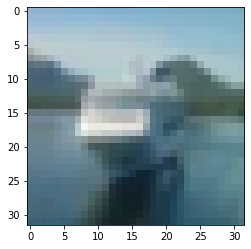

In [31]:
plt.imshow(img)
plt.show()

### LambdaCallback을 사용하여 Tensorboard에 Confusion Matrix 기록

In [11]:
import io
from sklearn.metrics import confusion_matrix

def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image

def plot_confusion_matrix(cm, class_names):

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    threshold = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

logdir = "logs/fit/cm/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer_cm = tf.summary.create_file_writer(logdir)

test_images = test_x[:100]
test_labels = np.argmax(test_y[:100], axis=1)

def log_confusion_matrix(epoch, logs):
    test_pred_raw = model.predict(test_images)
    test_pred = np.argmax(test_pred_raw, axis=1)
    
    classes = np.arange(10)
    cm = confusion_matrix(test_labels, test_pred, labels=classes)
    
    figure = plot_confusion_matrix(cm, class_names=classes)
    cm_image = plot_to_image(figure)

    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)